questo notebook si ferma alla creazione di un grafo esteso in cui sono inclusi nuovi archi predetti tramite link prediction, poi altri algoritmi useranno questo grafo e vedremo le differenze

In [1]:
import pandas as pd
import numpy as np
import networkx as nx

# Open ratings.csv file
ratings = pd.read_csv('ratings.csv')

In [2]:
# Open movies.csv file
movies = pd.read_csv("movies.csv")

In [3]:
# Merge ratings and movies
user_movie_matrix = pd.merge(ratings, movies, on="movieId")
print(user_movie_matrix.head())

   userId  movieId  rating  timestamp                        title  \
0       1        1     4.0  964982703             Toy Story (1995)   
1       1        3     4.0  964981247      Grumpier Old Men (1995)   
2       1        6     4.0  964982224                  Heat (1995)   
3       1       47     5.0  964983815  Seven (a.k.a. Se7en) (1995)   
4       1       50     5.0  964982931   Usual Suspects, The (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                               Comedy|Romance  
2                        Action|Crime|Thriller  
3                             Mystery|Thriller  
4                       Crime|Mystery|Thriller  


In [5]:
# # Check for common movies rated by multiple users
# common_movies = ratings.groupby("title").size().reset_index(name='count')
# print(common_movies[common_movies['count'] > 1].head(10))  # Print movies rated by more than one user

In [4]:
# Map rating to scores

mapping_score = {
    0.5:-1,
    1:-1,
    1.5:-0.5,
    2:0,
    2.5:0,
    3:0,
    3.5:0.5,
    4:1,
    4.5:1.1,
    5:1.2
}

Basandoci sulle ratings presenti nel dataset vado a proiettare il grafo movie_movie che mi consente di trovare la similarità tra i film. Il vettore di mappaggio è scelto arbitrariamente e serve a decidere quanto pesano le varie ratings.

In [5]:
import networkx as nx

# Create a directed graph
user_movie_graph = nx.Graph()

# Add nodes and edges
for _, row in user_movie_matrix.iterrows():
    user_movie_graph.add_node(row["userId"], bipartite=0)
    user_movie_graph.add_node(row["title"], bipartite=1, genre=row["genres"], movieId=row["movieId"])
    # user_movie_graph.add_edge(row["userId"], row["title"], weight=row["rating"])
    user_movie_graph.add_edge(row["userId"], row["title"], weight=mapping_score[row["rating"]])

# Debug print to check the graph construction
print(f"Nodes in the graph: {list(user_movie_graph.nodes(data=True))[:10]}")
print(f"Edges in the graph: {list(user_movie_graph.edges(data=True))[:10]}")

Nodes in the graph: [(1, {'bipartite': 0}), ('Toy Story (1995)', {'bipartite': 1, 'genre': 'Adventure|Animation|Children|Comedy|Fantasy', 'movieId': 1}), ('Grumpier Old Men (1995)', {'bipartite': 1, 'genre': 'Comedy|Romance', 'movieId': 3}), ('Heat (1995)', {'bipartite': 1, 'genre': 'Action|Crime|Thriller', 'movieId': 6}), ('Seven (a.k.a. Se7en) (1995)', {'bipartite': 1, 'genre': 'Mystery|Thriller', 'movieId': 47}), ('Usual Suspects, The (1995)', {'bipartite': 1, 'genre': 'Crime|Mystery|Thriller', 'movieId': 50}), ('From Dusk Till Dawn (1996)', {'bipartite': 1, 'genre': 'Action|Comedy|Horror|Thriller', 'movieId': 70}), ('Bottle Rocket (1996)', {'bipartite': 1, 'genre': 'Adventure|Comedy|Crime|Romance', 'movieId': 101}), ('Braveheart (1995)', {'bipartite': 1, 'genre': 'Action|Drama|War', 'movieId': 110}), ('Rob Roy (1995)', {'bipartite': 1, 'genre': 'Action|Drama|Romance|War', 'movieId': 151})]
Edges in the graph: [(1, 'Toy Story (1995)', {'weight': 1}), (1, 'Grumpier Old Men (1995)', {

In [6]:
users = {n for n, d in user_movie_graph.nodes(data=True) if d["bipartite"] == 0}
print(f"Users: {list(users)[:10]}")
print(f"Number of users: {len(users)}")

Users: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Number of users: 610


In [7]:
movies = {n for n, d in user_movie_graph.nodes(data=True) if d["bipartite"] == 1}
print(f"Movies: {list(movies)[:10]}")
print(f"Number of movies: {len(movies)}")

Movies: ['Asterix: The Land of the Gods (Astérix: Le domaine des dieux) (2014)', 'The Fox and the Hound 2 (2006)', 'Wolf (1994)', 'Blue Valentine (2010)', 'Den, The (2013)', 'Siam Sunset (1999)', 'Loose Cannons (1990)', 'My Girl (1991)', 'Zeitgeist: Addendum (2008)', 'Barcelona (1994)']
Number of movies: 9719


In [8]:
print(nx.is_bipartite(user_movie_graph))
print(nx.is_connected(user_movie_graph))

True
True


In [9]:
user_user_graph = nx.bipartite.weighted_projected_graph(user_movie_graph, users)
print(f"Nodes in the user-user graph: {list(user_user_graph.nodes(data=True))[:10]}")
print(f"Edges in the user-user graph: {list(user_user_graph.edges(data=True))[:10]}")
print(len(user_user_graph.nodes()))
print(len(user_user_graph.edges()))

Nodes in the user-user graph: [(1, {'bipartite': 0}), (2, {'bipartite': 0}), (3, {'bipartite': 0}), (4, {'bipartite': 0}), (5, {'bipartite': 0}), (6, {'bipartite': 0}), (7, {'bipartite': 0}), (8, {'bipartite': 0}), (9, {'bipartite': 0}), (10, {'bipartite': 0})]
Edges in the user-user graph: [(1, 2, {'weight': 2}), (1, 3, {'weight': 7}), (1, 4, {'weight': 45}), (1, 5, {'weight': 13}), (1, 6, {'weight': 33}), (1, 7, {'weight': 26}), (1, 8, {'weight': 15}), (1, 9, {'weight': 5}), (1, 10, {'weight': 6}), (1, 11, {'weight': 16})]
610
164054


In [12]:
#stampare il range di valori dei pesi degli archi nel grafo user-user per capire i valori da considerare
print(f"Edges in the user-user graph: {list(user_user_graph.edges(data=True))[:10]}")



Edges in the user-user graph: [(1, 2, {'weight': 2}), (1, 3, {'weight': 7}), (1, 4, {'weight': 45}), (1, 5, {'weight': 13}), (1, 6, {'weight': 33}), (1, 7, {'weight': 26}), (1, 8, {'weight': 15}), (1, 9, {'weight': 5}), (1, 10, {'weight': 6}), (1, 11, {'weight': 16})]


In [14]:
#stampa numero totale di archi presenti in user_user_graph
print(len(user_user_graph.edges()))

164054


In [15]:
# Funzione per analizzare il range dei pesi degli archi nel grafo user-user e verificare il numero totale di archi
def analyze_user_user_edge_weights(user_user_graph: nx.Graph, expected_total_edges: int):
    # Estrai i pesi degli archi tra gli utenti
    edge_weights = [data['weight'] for u, v, data in user_user_graph.edges(data=True)]

    # Stampa il range dei pesi
    print(f"Range dei pesi degli archi user-user: min={min(edge_weights)}, max={max(edge_weights)}")

    # Conta la distribuzione dei pesi
    weight_dict = {}
    for weight in edge_weights:
        if weight in weight_dict:
            weight_dict[weight] += 1
        else:
            weight_dict[weight] = 1

    print("Distribuzione dei pesi degli archi user-user:")
    for weight, count in sorted(weight_dict.items()):
        print(f"Peso: {weight}, Numero di archi: {count}")

    # Contare il numero di archi con peso diverso da zero
    total_non_zero = sum(count for weight, count in weight_dict.items() if weight != 0.0)
    print(f"Numero di archi con peso diverso da zero: {total_non_zero}")

    # Confronta il numero totale di archi con il valore atteso
    actual_total_edges = len(edge_weights)
    print(f"Numero totale di archi nel grafo user-user: {actual_total_edges}")
    if actual_total_edges == expected_total_edges:
        print("Il numero totale di archi è corretto.")
    else:
        print(f"ATTENZIONE: Il numero totale di archi è {actual_total_edges}, ma il valore atteso era {expected_total_edges}.")

    return weight_dict, edge_weights

# Chiamare la funzione con il numero di archi previsto (164054)
expected_total_edges = 164054
weight_dict, edge_weights = analyze_user_user_edge_weights(user_user_graph, expected_total_edges)


Range dei pesi degli archi user-user: min=1, max=1338
Distribuzione dei pesi degli archi user-user:
Peso: 1, Numero di archi: 18010
Peso: 2, Numero di archi: 14895
Peso: 3, Numero di archi: 12373
Peso: 4, Numero di archi: 10574
Peso: 5, Numero di archi: 9027
Peso: 6, Numero di archi: 7598
Peso: 7, Numero di archi: 6736
Peso: 8, Numero di archi: 6036
Peso: 9, Numero di archi: 5432
Peso: 10, Numero di archi: 4783
Peso: 11, Numero di archi: 4459
Peso: 12, Numero di archi: 4021
Peso: 13, Numero di archi: 3666
Peso: 14, Numero di archi: 3368
Peso: 15, Numero di archi: 3184
Peso: 16, Numero di archi: 2887
Peso: 17, Numero di archi: 2740
Peso: 18, Numero di archi: 2415
Peso: 19, Numero di archi: 2323
Peso: 20, Numero di archi: 2050
Peso: 21, Numero di archi: 1951
Peso: 22, Numero di archi: 1773
Peso: 23, Numero di archi: 1692
Peso: 24, Numero di archi: 1528
Peso: 25, Numero di archi: 1397
Peso: 26, Numero di archi: 1280
Peso: 27, Numero di archi: 1207
Peso: 28, Numero di archi: 1091
Peso: 29,

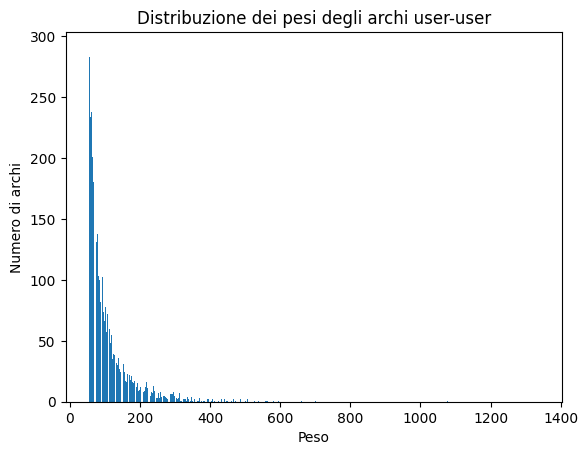

In [36]:
#bar plot di questi valori dei pesi
import matplotlib.pyplot as plt

filtered_weight_dict = {}
for k,v in weight_dict.items():
    if v < 300:
      filtered_weight_dict[k] = v

plt.bar(filtered_weight_dict.keys(), filtered_weight_dict.values())
plt.xlabel('Peso')
plt.ylabel('Numero di archi')
plt.title('Distribuzione dei pesi degli archi user-user')
plt.show()

In [10]:
# Project the graph using weights
movie_movie_graph = nx.bipartite.weighted_projected_graph(user_movie_graph, movies)
print(f"Nodes in movie_movie_graph: {list(movie_movie_graph.nodes(data=True))[:10]}")
print(f"Edges in movie_movie_graph: {list(movie_movie_graph.edges(data=True))[:10]}")

Nodes in movie_movie_graph: [('Asterix: The Land of the Gods (Astérix: Le domaine des dieux) (2014)', {'bipartite': 1, 'genre': 'Animation', 'movieId': 117545}), ('The Fox and the Hound 2 (2006)', {'bipartite': 1, 'genre': 'Adventure|Animation|Children|Comedy', 'movieId': 126921}), ('Wolf (1994)', {'bipartite': 1, 'genre': 'Drama|Horror|Romance|Thriller', 'movieId': 382}), ('Blue Valentine (2010)', {'bipartite': 1, 'genre': 'Drama|Romance', 'movieId': 78039}), ('Den, The (2013)', {'bipartite': 1, 'genre': 'Horror|Thriller', 'movieId': 113313}), ('Siam Sunset (1999)', {'bipartite': 1, 'genre': 'Comedy', 'movieId': 6402}), ('Loose Cannons (1990)', {'bipartite': 1, 'genre': 'Action|Comedy', 'movieId': 6560}), ('My Girl (1991)', {'bipartite': 1, 'genre': 'Comedy|Drama|Romance', 'movieId': 5970}), ('Zeitgeist: Addendum (2008)', {'bipartite': 1, 'genre': 'Documentary', 'movieId': 65225}), ('Barcelona (1994)', {'bipartite': 1, 'genre': 'Comedy|Romance', 'movieId': 417})]
Edges in movie_movie_

In [11]:
print(nx.is_connected(movie_movie_graph))

True


In [17]:
# 0: User, 1: Movie
def filter_nodes(graph: nx.Graph, node_type: int):
    return [n for n, d in graph.nodes(data=True) if d["bipartite"] == node_type]


In [18]:
def create_preference_vector(debug: bool, user_id: int, user_movie_graph: nx.Graph):
    # Get the edges for the user
    edges = {m: v for _, m, v in user_movie_graph.edges(user_id, data="weight")}

    if debug:
        print(f"Edges for user {user_id}: {list(edges)[:10]}")
        print(f"Number of edges for user {user_id}: {len(edges)}")

        for k, v in edges.items():
            print(k,v)

    # Sum of the ratings done by the user
    tot = sum(edges.values())

    if debug:
        print(f"Total for user {user_id}: {tot}")

    if tot > 0:
        print(f"User {user_id} has rated movies")
        return len(edges), {
            # Assign to each movie a normalized weight. The higher the rating, the higher the weight.
            # Se provo a prendere un film che non sta in edges, mi ritorna 0
            movie: edges.get(movie, 0) / tot
            for movie in filter_nodes(user_movie_graph, 1) # 1 : Movie
        }
    else:
        # User has not rated any movies or the sum of all weighted ratings is zero / negative
        print(f"User {user_id} has not rated any movies or the sum of all weighted ratings is zero / negative. All movies will have a weight of 1")
        return len(edges), {
            movie: 1 for movie in filter_nodes(user_movie_graph, 1) # Penso che dovremmo metterci zero come peso in questo caso
        }

Il vettore di personalizzazione assegna 0 a tutti i film non visti, mentre assegna valori normalizzati in base alla rating a tutti gli altri archi. Per come è stato costruito il vettore dei pesi delle ratings, al momento voti come 2, 2.5 e 3 vengono considerati allo stesso modo di film non visti

In [16]:
# # Test the function
# debug = True
# num, p_vec = create_preference_vector(debug, 1, user_movie_graph)

**Page Rank**

In [19]:
def predict_user(user_id, user_movie_graph: nx.Graph, movie_movie_graph: nx.Graph):
    _, p_vec = create_preference_vector(False, user_id, user_movie_graph)
    print(f"Preference vector for user {user_id}: {list(p_vec)[:10]}")

    already_seen = [movie for movie, p in p_vec.items() if p > 0]
    # Qua uso p > 0 perchè sopra assegno 0 ad ogni film non visto e valori diversi da 0 per quelli visti

    print(f"Already seen movies for user {user_id}: {list(already_seen)[:10]}")

    if len(already_seen) < 1:
        return []
    item_rank = nx.pagerank(movie_movie_graph, personalization=p_vec, alpha=0.95, weight="weight")
    print(f"Item rank for user {user_id}: {list(item_rank)[:10]}")
    s_t = [
        x for x in sorted(
            movie_movie_graph.nodes(), key=lambda x: item_rank[x] if x in item_rank else 0, reverse=True
            )
        if x not in already_seen
        ]

    return s_t

**Link Prediction with Adamic Adar Index**

L'**Adamic-Adar Index** è una misura utilizzata per calcolare la _similarità_ tra due nodi in una rete (o grafo) in base ai loro _vicini comuni_. Questa misura si basa sull'idea che i vicini comuni più _rari_ (cioè quelli con un basso grado) contribuiscano _maggiormente_ alla similarità rispetto a quelli con un alto grado.  [https://neo4j.com/docs/graph-data-science/current/alpha-algorithms/adamic-adar/]

La formula per calcolare l'indice di Adamic-Adar tra due nodi $u$ e $v$ è:

$$
A(u, v) = \sum_{w \in N(u) \cap N(v)} \frac{1}{\log |N(w)|}
$$

Dove:
- $N(u)$ è l'insieme dei vicini del nodo $u$.
- $N(v)$ è l'insieme dei vicini del nodo $v$.
- $N(w)$ è l'insieme dei vicini del nodo $w$ (nodo comune tra $u$ e $v$).
- $|N(w)|$ rappresenta il grado del nodo $w$.

In altre parole, l'indice somma i contributi inversamente proporzionali alla logaritmica del grado dei vicini comuni $w$.

L'Adamic-Adar Index viene ampiamente utilizzato nella **link prediction** nei sistemi di raccomandazione, ad esempio per predire nuovi film che un utente potrebbe apprezzare. Ecco i motivi principali:

1. **Valorizzazione dei vicini rari**:
   - La presenza di vicini comuni rari è considerata più significativa nella formazione di nuovi collegamenti, poiché suggerisce una connessione più forte tra i nodi.
   - Ad esempio, in una rete sociale, avere amici comuni con pochi altri contatti può essere indicativo di una relazione più stretta.

2. **Efficienza computazionale**:
   - L'indice è relativamente semplice da calcolare per coppie di nodi e può essere implementato in modo efficace anche su grandi reti sparse.

3. **Adattabilità a diversi domini**:
   - L'indice si applica bene a reti sociali, biologiche, di co-autorship, e molte altre tipologie di grafo.

4. **Rilevanza statistica**:
   - Penalizzando i nodi con alti gradi ($\log |N(w)|$), l'Adamic-Adar Index riduce l'effetto di "hub" o nodi centrali nella rete, rendendo la misura più bilanciata.

Nella link prediction, l'indice viene utilizzato per stimare la _probabilità_ che un collegamento esista (o si formi in futuro) tra due nodi non direttamente collegati. In particolare:

1. Si calcolano gli indici Adamic-Adar per tutte le coppie di nodi non collegati.
2. Si ordinano le coppie in base ai valori di similarità.
3. Si predice che i collegamenti con i valori più alti abbiano la maggiore probabilità di esistere o di formarsi.

Immaginiamo un grafo con i seguenti nodi e connessioni:
- Nodo $u$ è connesso a $a, b$.
- Nodo $v$ è connesso a $b, c$.

Il vicinato comune tra $u$ e $v$ è costituito dal nodo $b$. Supponendo che $|N(b)| = 10$, il contributo di $b$ all'indice Adamic-Adar sarà:

$$
\frac{1}{\log 10} \approx 0.434
$$

Se ci sono più vicini comuni, i loro contributi saranno sommati per ottenere il valore finale dell'indice.

Nonostante l'efficacia in molti scenari, l'Adamic-Adar Index presenta alcune limitazioni:
- **Bias verso nodi con basso grado**: Questa caratteristica può risultare svantaggiosa in alcune reti dove gli hub giocano un ruolo cruciale.
- **Non considera i pesi degli archi**: La versione standard non tiene conto di pesi o altre proprietà degli archi, che potrebbero essere rilevanti in applicazioni specifiche.


In [17]:
#Adamic Adar iniziale che semplicemente calcola le connessioni, e l'output è 13318643

# import numpy as np
# # Calcolo dell'indice di Adamic-Adar
# def calculate_adamic_adar(graph):
#     scores = []
#     for u, v in nx.non_edges(graph):
#         common_neighbors = set(nx.common_neighbors(graph, u, v))
#         if common_neighbors:
#             score = sum(1 / np.log(len(list(graph.neighbors(w)))) for w in common_neighbors)
#             scores.append((u, v, score))
#     return scores


In [18]:
# # Uso delle funzioni
# adamic_adar_scores = calculate_adamic_adar(user_movie_graph)

In [19]:
# print("The link predicted are # ", len(adamic_adar_scores))

In [21]:
#NUOVA ADAMIC ADAR
import numpy as np
# Modifica per calcolare Adamic-Adar con il tipo di link
def calculate_adamic_adar(graph):
    scores = []
    for u, v in nx.non_edges(graph):
        common_neighbors = set(nx.common_neighbors(graph, u, v))
        if common_neighbors:
            score = sum(1 / np.log(len(list(graph.neighbors(w)))) for w in common_neighbors)
            # Determinare il tipo di link
            type_u = graph.nodes[u].get('bipartite', -1)
            type_v = graph.nodes[v].get('bipartite', -1)
            if type_u == 0 and type_v == 1:  # user-movie
                link_type = "user-movie"
            elif type_u == 1 and type_v == 1:  # movie-movie
                link_type = "movie-movie"
            elif type_u == 0 and type_v == 0:  # user-user (poco probabile nel tuo caso)
                link_type = "user-user"
            else:
                link_type = "unknown"
            # Aggiungere le informazioni
            scores.append((u, v, score, link_type))
    return scores

# Calcolo dei punteggi Adamic-Adar con tipo di link
adamic_adar_scores = calculate_adamic_adar(user_user_graph)

print("The link predicted are # ", len(adamic_adar_scores))

# Salva i risultati in un CSV
adamic_adar_df = pd.DataFrame(adamic_adar_scores, columns=["Node u", "Node v", "Score", "LinkType"])
adamic_adar_df.to_csv("adamic_adar_scores_user_user.csv", index=False)

print("Adamic-Adar scores salvati in 'adamic_adar_scores_user_user.csv'")


The link predicted are #  21691
Adamic-Adar scores salvati in 'adamic_adar_scores_user_user.csv'


In [22]:
#salva il file csv in google drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [24]:
#salva il file adamic_adar_scores.csv in google drive
adamic_adar_df.to_csv('/content/drive/My Drive/adamic_adar_scores_user_user.csv', index=False)


In [25]:
#stampa le quanti link ci sono per ogni tipo
print(adamic_adar_df['LinkType'].value_counts())

LinkType
user-user    21691
Name: count, dtype: int64


CONTROLLO DEGLI SCORE DI ADAMIC ADAR PER USER-USER_GRAPH

In [28]:
# Analisi degli score dal DataFrame salvato
def analyze_adamic_adar_from_df(adamic_adar_df):
    # Calcola il range degli score
    min_score = adamic_adar_df["Score"].min()
    max_score = adamic_adar_df["Score"].max()
    print(f"Range degli score Adamic-Adar: min={min_score}, max={max_score}")

    # Conta la distribuzione degli score (opzionalmente arrotondati)
    adamic_adar_df["RoundedScore"] = adamic_adar_df["Score"].round(2)
    score_distribution = adamic_adar_df["RoundedScore"].value_counts().sort_index()

    # print("Distribuzione degli score Adamic-Adar:")
    # for score, count in score_distribution.items():
    #     print(f"Score: {score}, Numero di link: {count}")

    return score_distribution

# Esegui l'analisi
score_distribution = analyze_adamic_adar_from_df(adamic_adar_df)


Range degli score Adamic-Adar: min=9.879585259240814, max=88.57402962234279


In [30]:
# Analisi degli score dal DataFrame salvato
def analyze_adamic_adar_from_df(adamic_adar_df):
    # Calcola il range degli score
    min_score = adamic_adar_df["Score"].min()
    max_score = adamic_adar_df["Score"].max()
    print(f"Range degli score Adamic-Adar: min={min_score}, max={max_score}")

    # Conta la distribuzione degli score (opzionalmente arrotondati)
    adamic_adar_df["RoundedScore"] = adamic_adar_df["Score"].round(2)
    score_distribution = adamic_adar_df["RoundedScore"].astype(int).value_counts().sort_index()


    print("Distribuzione degli score Adamic-Adar:")
    for score, count in score_distribution.items():
        print(f"Score: {score}, Numero di link: {count}")

    return score_distribution

# Esegui l'analisi
score_distribution = analyze_adamic_adar_from_df(adamic_adar_df)


Range degli score Adamic-Adar: min=9.879585259240814, max=88.57402962234279
Distribuzione degli score Adamic-Adar:
Score: 9, Numero di link: 1
Score: 10, Numero di link: 1
Score: 12, Numero di link: 4
Score: 13, Numero di link: 9
Score: 14, Numero di link: 17
Score: 15, Numero di link: 18
Score: 16, Numero di link: 61
Score: 17, Numero di link: 144
Score: 18, Numero di link: 192
Score: 19, Numero di link: 69
Score: 20, Numero di link: 21
Score: 21, Numero di link: 23
Score: 22, Numero di link: 28
Score: 23, Numero di link: 30
Score: 24, Numero di link: 66
Score: 25, Numero di link: 119
Score: 26, Numero di link: 200
Score: 27, Numero di link: 149
Score: 28, Numero di link: 119
Score: 29, Numero di link: 203
Score: 30, Numero di link: 205
Score: 31, Numero di link: 137
Score: 32, Numero di link: 260
Score: 33, Numero di link: 252
Score: 34, Numero di link: 238
Score: 35, Numero di link: 268
Score: 36, Numero di link: 350
Score: 37, Numero di link: 393
Score: 38, Numero di link: 378
Scor

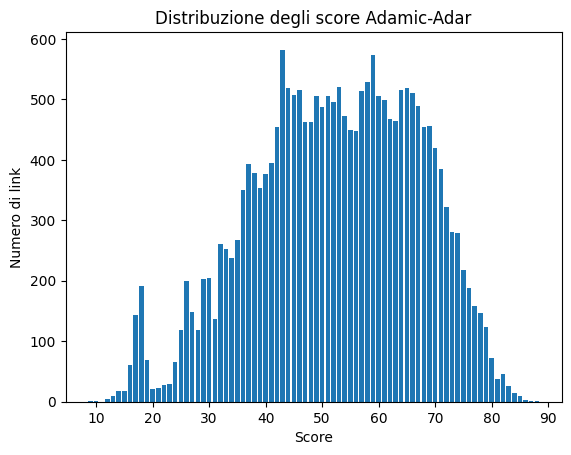

In [31]:
#bar plot dei valori della score_distribution (interi)
import matplotlib.pyplot as plt
plt.bar(score_distribution.index, score_distribution.values)
plt.xlabel('Score')
plt.ylabel('Numero di link')
plt.title('Distribuzione degli score Adamic-Adar')
plt.show()


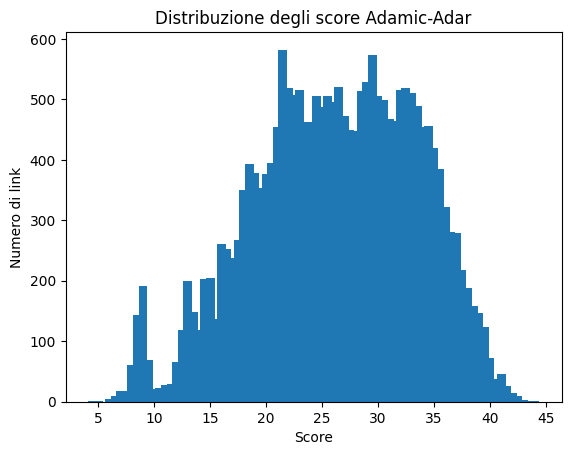

In [39]:
#dividi per due tutti gli score ottenuti da adamic adar per spostare la distribuzione a sinistra

#bar plot dei valori della score_distribution (interi)
import matplotlib.pyplot as plt
plt.bar(score_distribution.index/2, score_distribution.values)
plt.xlabel('Score')
plt.ylabel('Numero di link')
plt.title('Distribuzione degli score Adamic-Adar')
plt.show()




In [35]:
# #controllo duplicati:
# print(len(adamic_adar_scores))  # Numero totale di link predetti
# print(len(set((min(u, v), max(u, v)) for u, v, _, _ in adamic_adar_scores)))  # Numero di link univoci


13318643
13318643


In [26]:
#altri print di debug utili per controllare "calculate_adamic_adar"
print(adamic_adar_df.head())


   Node u  Node v      Score   LinkType
0       1     578  27.100798  user-user
1       1     556  61.756292  user-user
2       1     397  33.213062  user-user
3       1     175  19.113945  user-user
4       1     496  61.782146  user-user


In [25]:
# print(adamic_adar_df['Score'].describe())


count    1.331864e+07
mean     3.875807e-01
std      1.224023e+00
min      1.265780e-01
25%      1.306593e-01
50%      1.460960e-01
75%      2.969011e-01
max      4.679364e+02
Name: Score, dtype: float64


In [26]:
# print(adamic_adar_df[adamic_adar_df['LinkType'] == 'user-movie'].head())

Empty DataFrame
Columns: [Node u, Node v, Score, LinkType]
Index: []


In [27]:
# print(adamic_adar_df[adamic_adar_df['LinkType'] == 'movie-movie'].head())

                 Node u                     Node v     Score     LinkType
5286  About Time (2013)       Avengers, The (2012)  1.602581  movie-movie
5287  About Time (2013)  Lady and the Tramp (1955)  0.289334  movie-movie
5288  About Time (2013)         Coffee Town (2013)  0.164107  movie-movie
5289  About Time (2013)      Serious Man, A (2009)  0.266016  movie-movie
5290  About Time (2013)  Drop Dead Gorgeous (1999)  0.126578  movie-movie


In [30]:
# print(adamic_adar_df[adamic_adar_df['LinkType'] == 'movie-movie'])

                               Node u  \
5286                About Time (2013)   
5287                About Time (2013)   
5288                About Time (2013)   
5289                About Time (2013)   
5290                About Time (2013)   
...                               ...   
13318638  I Capture the Castle (2003)   
13318639        Impostors, The (1998)   
13318640        Impostors, The (1998)   
13318641               Hatari! (1962)   
13318642             Road, The (2009)   

                                             Node v     Score     LinkType  
5286                           Avengers, The (2012)  1.602581  movie-movie  
5287                      Lady and the Tramp (1955)  0.289334  movie-movie  
5288                             Coffee Town (2013)  0.164107  movie-movie  
5289                          Serious Man, A (2009)  0.266016  movie-movie  
5290                      Drop Dead Gorgeous (1999)  0.126578  movie-movie  
...                                          

In [34]:
# #salva un csv per il print sopra di "adamic_adar_df['LinkType'] == 'movie-movie']"
# movie_movie_df = adamic_adar_df[adamic_adar_df['LinkType'] == 'movie-movie']
# movie_movie_df.to_csv('movie_movie_df.csv', index=False)


In [28]:
# print(adamic_adar_df[adamic_adar_df['LinkType'] == 'user-user'].head())

  Node u Node v      Score   LinkType
0      1      2   0.450334  user-user
1      1      3   1.926414  user-user
2      1      4  10.017087  user-user
3      1      5   2.544062  user-user
4      1      6   7.206555  user-user


In [38]:
# #stampa il massimo valore di score ottenuto
# print(adamic_adar_df['Score'].max())

467.9363982177409


In [39]:
# #stampa numero dei vicini in comune tra il nodo con id 494 e quello con id 599
# print(len(set(nx.common_neighbors(user_movie_graph, 494, 599))))

# #viene 22 e ha senso perché lo score era il più alto cioè 467

22


In [40]:
# #stampa numero dei vicini in comune tra il nodo con id 274 e 380
# print(len(set(nx.common_neighbors(user_movie_graph, 274, 380))))

# #qua lo score era 200.8

640


In [43]:
# #stampa n° vicini tra nodo 275 e 366
# print(len(set(nx.common_neighbors(user_movie_graph, 275, 366))))

4


In [42]:
# #stampa numero dei vicini in comune tra il nodo con id 274 e 422
# print(len(set(nx.common_neighbors(user_movie_graph, 274, 422))))

# #idem per 274 e 411
# print(len(set(nx.common_neighbors(user_movie_graph, 274, 411))))

# #ha senso perché hanno uno score simile tipo "10.7"


42
50


**PROVA DELLA SECONDA VERSIONE DI ADAMIC ADAR**

In [37]:
# # Nuova funzione Adamic-Adar per link user-movie
# def calculate_adamic_adar_user_movie(graph):
#     scores = []
#     users = [n for n, d in graph.nodes(data=True) if d.get('bipartite') == 0]  # Utenti
#     movies = [n for n, d in graph.nodes(data=True) if d.get('bipartite') == 1]  # Film

#     for user in users:
#         for movie in movies:
#             # Verifica che non ci sia già un collegamento diretto
#             if not graph.has_edge(user, movie):
#                 # Calcola i vicini comuni
#                 common_neighbors = set(nx.common_neighbors(graph, user, movie))
#                 if common_neighbors:
#                     # Calcola il punteggio Adamic-Adar
#                     score = sum(1 / np.log(len(list(graph.neighbors(w)))) for w in common_neighbors)
#                     scores.append((user, movie, score, "user-movie"))
#     return scores

# # Calcolo dei punteggi user-movie
# adamic_adar_user_movie_scores = calculate_adamic_adar_user_movie(user_movie_graph)

# # Salva i risultati in un CSV
# adamic_adar_user_movie_df = pd.DataFrame(adamic_adar_user_movie_scores, columns=["User", "Movie", "Score", "LinkType"])
# adamic_adar_user_movie_df.to_csv("adamic_adar_user_movie_scores.csv", index=False)

# # Stampa i risultati principali
# print(adamic_adar_user_movie_df.head())
# print(adamic_adar_user_movie_df['LinkType'].value_counts())


Empty DataFrame
Columns: [User, Movie, Score, LinkType]
Index: []
Series([], Name: count, dtype: int64)


Ritorna un Empty DataFrame. Forse perché l'indice di Adamic-Adar non trova vicini comuni user−movie nel grafo bipartito puro.

Questo perché utenti e film non condividono vicini nel modello bipartito tradizionale.

**PROVA ADAMIC ADAR CON CONNESSIONI PESATE**

In [22]:
# #PROVAAAAAAAAA
# # Funzione di controllo per vicini comuni e rating alti
# def print_common_neighbors(user_id_1, user_id_2, user_movie_graph):
#     common_neighbors = set(nx.common_neighbors(user_movie_graph, user_id_1, user_id_2))

#     # Mostra quanti film in comune hanno i due utenti
#     print(f"User {user_id_1} and User {user_id_2} have {len(common_neighbors)} common movies.")

#     # Filtra i film con rating alto (>= 4) per entrambi gli utenti
#     high_rated_common_movies = [
#         movie for movie in common_neighbors
#         if user_movie_graph[user_id_1][movie]["weight"] >= 4 and user_movie_graph[user_id_2][movie]["weight"] >= 4
#     ]

#     print(f"Common movies with high ratings: {high_rated_common_movies}")

#     # Film visti dall'utente
#     movies_seen_by_user1 = set(user_movie_graph.neighbors(user_id_1))

#     # Film con rating alti ma non ancora visti
#     unseen_movies_by_user1 = [
#       movie for movie in high_rated_common_movies
#       if movie not in movies_seen_by_user1 # Se user1 non ha visto questo film
#     ]

#     print(f"Movies with high ratings from user {user_id_2} that user {user_id_1} hasn't seen: {unseen_movies_by_user1}")

#     # Se non ci sono film con rating alto che user1 non ha visto, puoi anche aggiungere un messaggio
#     if not unseen_movies_by_user1:
#         print(f"User {user_id_1} has already seen all the high-rated common movies of user {user_id_2}.")


In [44]:
# def calculate_adamic_adar_weighted(graph):
#     scores = []
#     for u, v in nx.non_edges(graph):
#         common_neighbors = set(nx.common_neighbors(graph, u, v))
#         if common_neighbors:
#             score = 0
#             for w in common_neighbors:
#                 weight_u_w = graph[u][w]['weight']  # peso della connessione u -> w
#                 weight_v_w = graph[v][w]['weight']  # peso della connessione v -> w
#                 # Somma dei pesi dei vicini comuni, penalizzati dalla "logaritmica" di vicinanza
#                 score += (weight_u_w + weight_v_w) / np.log(len(list(graph.neighbors(w))))
#                 # Aggiungi un controllo per i vicini comuni tra utenti
#             print_common_neighbors(u, v, graph)
#             scores.append((u, v, score))
#     return scores


In [23]:
# #PROVA 2 delle 2 di notte del 30/12
# # Funzione che calcola Adamic-Adar ponderato
# def calculate_adamic_adar_weighted(graph):
#     scores = []
#     # Itera su tutte le coppie di nodi non collegati (non-edges)
#     for u, v in nx.non_edges(graph):
#         # Trova i vicini comuni
#         common_neighbors = set(nx.common_neighbors(graph, u, v))
#         if common_neighbors:  # Solo se ci sono vicini comuni
#             score = 0
#             for w in common_neighbors:
#                 # Ottieni i pesi delle connessioni u -> w e v -> w
#                 weight_u_w = graph[u][w]['weight']  # peso della connessione u -> w
#                 weight_v_w = graph[v][w]['weight']  # peso della connessione v -> w
#                 # Somma dei pesi dei vicini comuni, penalizzati dalla logaritmica della vicinanza
#                 score += (weight_u_w + weight_v_w) / np.log(len(list(graph.neighbors(w))))

#             # Aggiungi un controllo per i vicini comuni tra utenti
#             print_common_neighbors(u, v, graph)

#             # Aggiungi il punteggio finale per la coppia di nodi
#             scores.append((u, v, score))

#     return scores

In [25]:
# ##PROVA ADAMIC ADAR PESATO CHE CERCA UTENTI SIMILI --> mattina del 30/12
# def calculate_adamic_adar_weighted(graph):
#     scores = []
#     # Itera su tutte le coppie di nodi non collegati
#     for u, v in nx.non_edges(graph):
#         # Trova i vicini comuni
#         common_neighbors = set(nx.common_neighbors(graph, u, v))
#         if common_neighbors:
#             score = 0
#             for w in common_neighbors:
#                 # Ottieni i pesi delle connessioni u -> w e v -> w
#                 weight_u_w = graph[u][w]['weight'] if 'weight' in graph[u][w] else 1
#                 weight_v_w = graph[v][w]['weight'] if 'weight' in graph[v][w] else 1
#                 # Calcolo ponderato
#                 try:
#                     score += (weight_u_w + weight_v_w) / np.log(1 + len(list(graph.neighbors(w))))
#                 except ZeroDivisionError:
#                     score += 0  # Gestisce il caso di isolati o divisori nulli

#             # Aggiungi il punteggio per la coppia di nodi
#             scores.append((u, v, score))

#     return scores


In [26]:
# # Calcolare i punteggi Adamic-Adar ponderati per il grafo user-user
# adamic_adar_weighted_scores = calculate_adamic_adar_weighted(user_user_graph)

In [27]:
# # Stampa i primi 10 punteggi calcolati per debug
# print("Adamic-Adar Weighted Scores (sample):", adamic_adar_weighted_scores[:10])

Adamic-Adar Weighted Scores (sample): [(1, 578, 1184.8683092521587), (1, 556, 2347.362716359767), (1, 397, 1550.561663266756), (1, 175, 1040.3229005690928), (1, 496, 2379.309351534518), (1, 306, 2498.61799293916), (1, 506, 1861.890405021799), (2, 3, 407.6965799700138), (2, 516, 530.3924746964949), (2, 518, 421.16667821315775)]


In [28]:
# #print
# print("The link predicted are # ", len(adamic_adar_weighted_scores))

The link predicted are #  21691


In [48]:
# #stampa esempi di link predetti
# print(adamic_adar_weighted_scores[:10])

[(1, 578, 3526.4927806268615), (1, 556, 15869.098020837551), (1, 397, 5819.139138021524), (1, 175, 2345.9831338514477), (1, 496, 13768.000542506936), (1, 306, 24512.035582820736), (1, 506, 10731.13921744908), (2, 3, 1071.5295243425253), (2, 516, 1563.6886912411705), (2, 518, 1194.0790089910693)]


In [64]:
# # Aggiungi il controllo per evitare di suggerire film già visti
# def check_if_seen(user_id, movie_id, user_movie_graph):
#     return user_movie_graph.has_edge(user_id, movie_id)

# # Controllo per ogni link predetto
# for user_id, movie_id, score in adamic_adar_weighted_scores:
#     if not check_if_seen(user_id, movie_id, user_movie_graph):
#         print(f"User {user_id} -> Movie {movie_id} has score {score} and is a valid prediction.")
#     else:
#         print(f"User {user_id} -> Movie {movie_id} is already seen, skipping.")


Output streaming troncato alle ultime 5000 righe.
User 320 -> Movie 361 has score 3416.643835874459 and is a valid prediction.
User 320 -> Movie 363 has score 1228.1967967248054 and is a valid prediction.
User 320 -> Movie 364 has score 720.0632394910458 and is a valid prediction.
User 320 -> Movie 369 has score 3594.5987561137354 and is a valid prediction.
User 320 -> Movie 370 has score 4206.745154742232 and is a valid prediction.
User 320 -> Movie 372 has score 5259.672888494795 and is a valid prediction.
User 320 -> Movie 373 has score 2677.6598869976488 and is a valid prediction.
User 320 -> Movie 374 has score 1257.6420654132855 and is a valid prediction.
User 320 -> Movie 376 has score 5238.671671781128 and is a valid prediction.
User 320 -> Movie 379 has score 1484.0376546693492 and is a valid prediction.
User 320 -> Movie 383 has score 585.336243298688 and is a valid prediction.
User 320 -> Movie 384 has score 1568.2992714608145 and is a valid prediction.
User 320 -> Movie 386

**Aggiunta link predetti al grafo**

I link predetti dalla link prediction verranno aggiunti al grafo user-movie graph [DA DECIDERE] al fine di aiutare la prediction tramite Page Ranking, arricchendola con le nuove informazioni ottenute.

In [21]:
# Aggiunta di link predetti
def add_predicted_links(graph, predicted_edges, threshold):
    for u, v, score in predicted_edges:
        if score > threshold:  #threshold is 50
            graph.add_edge(u, v, weight=score)
    return graph


In [22]:
user_user_graph_extended = add_predicted_links(user_user_graph, adamic_adar_scores, 50)

ValueError: too many values to unpack (expected 3)

**Prediction**

In [ ]:
# Test the prediction
user = 10
s_t = predict_user(user, user_movie_graph, movie_movie_graph)
print(f"Predicted movies for user {user}: {s_t[:10]}")

In [ ]:
# Make all predictions
predictions = {}
for user in filter_nodes(user_movie_graph, 0):
    predictions[user] = predict_user(user, user_movie_graph, movie_movie_graph)[:10]

In [ ]:
# CONTROLLARE COSA FA QUESTO

# Funzione per calcolare la similarità tra due film usando i vicini comuni
def common_neighbors_similarity(movie1, movie2, user_movie_graph):
    users1 = user_movie_graph.edges.filter(col("dst") == movie1).select("src").rdd.flatMap(lambda x: x).collect()
    users2 = user_movie_graph.edges.filter(col("dst") == movie2).select("src").rdd.flatMap(lambda x: x).collect()
    
    # Calcolare i vicini comuni
    common_users = set(users1).intersection(set(users2))
    return len(common_users)

In [ ]:
# Funzione per predire i link tra un utente e un film
def predict_links(user_id, movie_id, user_movie_graph):
    movies = user_movie_graph.vertices.filter(col("bipartite") == 1).select("id").rdd.map(lambda row: row[0]).collect()
    
    similarity_scores = []
    for movie in movies:
        if movie != movie_id:
            score = common_neighbors_similarity(movie_id, movie, user_movie_graph)
            similarity_scores.append((movie, score))
    
    # Ordina i film in base alla similarità
    similarity_scores.sort(key=lambda x: x[1], reverse=True)
    return similarity_scores[:10]  # Restituisci i 10 film più simili